## An Analysis of Crime in NYC



## SETUP

In [1]:
# Importing all relevant packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
%pip install geopandas
import geopandas as gpd
from shapely.geometry import Point

Note: you may need to restart the kernel to use updated packages.


- Class A felonies: Class A felonies are punishable by up to life in prison. Examples of Class A felonies include murder in the 1st degree and arson in the 1st
- Class B felonies: Class B felonies are punishable by up to 25 years in prison. Examples of Class B felonies include assault in the 1st degree and sex trafficking.
- Class C felonies: Class C felonies are punishable by up to 15 years in prison. Examples of Class C felonies include aggravated criminal possession of a weapon and aggravated vehicular assault.
- Class D felonies: Class D felonies are punishable by up to 7 years in prison. Examples of Class D felonies include reckless assault of a child and aggravated identity theft.
- Class E felonies: Class E felonies are punishable by up to 4 years in prison. Examples of Class E felonies include defrauding the government and unlawfully concealing a will.

In [2]:
arrests = pd.read_csv('/Users/abbascauser/Documents/Data Science/Capstone/NYPD_Arrests_Data__Historic_.csv')
cd = gpd.read_file('/Users/abbascauser/Documents/Data Science/Capstone/nycd_23b/nycd.shp') #read in the shapefile with the Community District BORO Codes
demo_age = pd.read_csv('/Users/abbascauser/Documents/Data Science/Capstone/cd_demo_age_gender.csv')
demo_econ = pd.read_csv('/Users/abbascauser/Documents/Data Science/Capstone/cd_demo_race_economics.csv')

In [3]:
arrests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5498650 entries, 0 to 5498649
Data columns (total 24 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   ARREST_KEY              int64  
 1   ARREST_DATE             object 
 2   PD_CD                   float64
 3   PD_DESC                 object 
 4   KY_CD                   float64
 5   OFNS_DESC               object 
 6   LAW_CODE                object 
 7   LAW_CAT_CD              object 
 8   ARREST_BORO             object 
 9   ARREST_PRECINCT         int64  
 10  JURISDICTION_CODE       float64
 11  AGE_GROUP               object 
 12  PERP_SEX                object 
 13  PERP_RACE               object 
 14  X_COORD_CD              float64
 15  Y_COORD_CD              float64
 16  Latitude                float64
 17  Longitude               float64
 18  Lon_Lat                 object 
 19  Zip Codes               float64
 20  Community Districts     float64
 21  Borough Boundaries      float64

In [4]:
arrests.shape

(5498650, 24)

In [5]:
arrests.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,...,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,236791704,11/22/2021,581.0,NaN,NaN,NaN,PL 2225001,M,M,28,...,997427.0,230378.0,40.799009,-73.952409,POINT (-73.95240854099995 40.799008797000056),12423.0,18.0,4.0,36.0,18.0
1,237354740,12/04/2021,153.0,RAPE 3,104.0,RAPE,PL 1302502,F,B,41,...,1013232.0,236725.0,40.816392,-73.895296,POINT (-73.89529641399997 40.816391847000034),10937.0,8.0,5.0,43.0,24.0
2,236081433,11/09/2021,681.0,"CHILD, ENDANGERING WELFARE",233.0,SEX CRIMES,PL 2601001,M,Q,113,...,1046367.0,186986.0,40.679700,-73.776047,POINT (-73.77604736799998 40.67970040800003),24669.0,41.0,3.0,46.0,71.0
3,32311380,06/18/2007,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,M,Q,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192799737,01/26/2019,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,F,M,25,...,1000555.0,230994.0,40.800694,-73.941109,POINT (-73.94110928599997 40.800694331000045),13093.0,7.0,4.0,36.0,16.0


In [6]:
arrests.shape

(5498650, 24)

In [7]:
# Filtering for felonies only

arrests = arrests[arrests['LAW_CAT_CD']=="F"]

In [8]:
# Dropping rows where offense is nan

arrests = arrests.dropna(subset=['OFNS_DESC'])
arrests.shape


(1558079, 24)

In [9]:
# Mapping the arrests locations within community districts so we can port over demographic data. This will be used in the next round

gdf = gpd.GeoDataFrame(arrests, geometry=gpd.points_from_xy(arrests.X_COORD_CD, arrests.Y_COORD_CD, crs="EPSG:2263"))
mapped_data = gpd.sjoin(gdf, cd, how='left', op="within")

/Users/abbascauser/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [10]:
mapped_data.rename(columns={'BoroCD': 'cd_number'}, inplace=True)
mapped_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1558079 entries, 1 to 5498646
Data columns (total 29 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   ARREST_KEY              1558079 non-null  int64   
 1   ARREST_DATE             1558079 non-null  object  
 2   PD_CD                   1558042 non-null  float64 
 3   PD_DESC                 1558079 non-null  object  
 4   KY_CD                   1558033 non-null  float64 
 5   OFNS_DESC               1558079 non-null  object  
 6   LAW_CODE                1558079 non-null  object  
 7   LAW_CAT_CD              1558079 non-null  object  
 8   ARREST_BORO             1558079 non-null  object  
 9   ARREST_PRECINCT         1558079 non-null  int64   
 10  JURISDICTION_CODE       1558074 non-null  float64 
 11  AGE_GROUP               1558076 non-null  object  
 12  PERP_SEX                1558079 non-null  object  
 13  PERP_RACE               1558079 no

In [11]:
demo_age.head()

,cd_name,cd_number,borough,pop_2000,pop_2010,pop_estimate_acs,pop_change_00_10,pop_pct_female_under_5,pop_pct_female_5_9,pop_pct_female_10_14,...,pop_pct_male_60_64,pop_pct_male_65_69,pop_pct_male_70_74,pop_pct_male_75_79,pop_pct_male_80_84,pop_pct_male_85_over,under18_rate,moe_under18_rate,over65_rate,moe_over65_rate
0,Bronx Community District 1,201,Bronx,82159,91497,101542,0.11,3.6,4.4,3.5,...,1.6,0.9,1.1,0.8,0.3,0.1,29.7,1.3,9.0,0.5
1,Bronx Community District 2,202,Bronx,46824,52246,70144,0.12,3.3,3.5,3.4,...,2.0,1.1,0.8,0.8,0.3,0.3,27.5,1.2,9.2,0.6
2,Bronx Community District 3,203,Bronx,68574,79762,110290,0.16,4.4,4.0,4.0,...,2.1,1.4,0.8,0.8,0.4,0.2,29.1,1.1,9.2,0.5
3,Bronx Community District 6,206,Bronx,75688,83268,108893,0.10,4.8,3.5,3.5,...,1.9,1.4,1.0,0.9,0.3,0.3,28.3,1.2,9.6,0.5
4,Bronx Community District 4,204,Bronx,139563,146441,161994,0.05,3.5,4.1,4.3,...,2.0,1.3,0.9,0.6,0.4,0.3,27.7,1.0,9.7,0.5


In [12]:
demo_econ.head()

,cd_name,cd_number,borough,pct_foreign_born,moe_foreign_born,lep_rate,moe_lep_rate,pct_white_nh,pct_black_nh,pct_asian_nh,...,pct_hh_rent_burd,moe_hh_rent_burd,pct_bach_deg,moe_bach_deg,unemployment,moe_unemployment,mean_commute,moe_mean_commute,crime_count,crime_per_1000
0,Bronx Community District 1,201,Bronx,29.3,1.6,29.5,1.6,2.1,28.8,0.5,...,49.4,2.1,11.3,1.0,6.4,0.8,42.5,2.5,2205,21.7
1,Bronx Community District 2,202,Bronx,34.6,1.8,30.6,1.8,1.9,28.4,1.1,...,53.8,2.5,14.2,1.2,6.4,0.8,44.9,2.9,864,12.3
2,Bronx Community District 3,203,Bronx,31.7,1.3,25.9,1.3,1.2,35.8,0.8,...,48.0,2.0,14.1,1.1,6.6,0.7,43.9,2.6,1495,13.6
3,Bronx Community District 6,206,Bronx,32.6,1.5,27.5,1.5,6.1,27.0,1.3,...,55.1,2.0,12.6,1.1,8.4,0.8,44.4,2.4,1312,12.0
4,Bronx Community District 4,204,Bronx,42.7,1.3,35.8,1.4,1.9,28.7,1.3,...,54.0,1.7,15.8,1.0,6.4,0.6,41.9,1.8,2359,14.6


In [13]:
# Merging the age and economic demographic data sets to arrests

arrests = pd.merge(mapped_data, demo_age, on='cd_number', how='left')
arrests = pd.merge(arrests, demo_econ, on='cd_number',how='left')

arrests.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1558079 entries, 0 to 1558078
Data columns (total 98 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   ARREST_KEY              1558079 non-null  int64   
 1   ARREST_DATE             1558079 non-null  object  
 2   PD_CD                   1558042 non-null  float64 
 3   PD_DESC                 1558079 non-null  object  
 4   KY_CD                   1558033 non-null  float64 
 5   OFNS_DESC               1558079 non-null  object  
 6   LAW_CODE                1558079 non-null  object  
 7   LAW_CAT_CD              1558079 non-null  object  
 8   ARREST_BORO             1558079 non-null  object  
 9   ARREST_PRECINCT         1558079 non-null  int64   
 10  JURISDICTION_CODE       1558074 non-null  float64 
 11  AGE_GROUP               1558076 non-null  object  
 12  PERP_SEX                1558079 non-null  object  
 13  PERP_RACE               1558079 no

In [14]:
# Given unemployment is a key feature, we will see where there are nulls. Tge difference of 5539 aligns with the difference we see above

rows_with_nulls = arrests[arrests['unemployment'].isnull()]
rows_with_nulls.shape

(5539, 98)

In [15]:
# Dont need to worry about the ones that are different below as we will not be using them

arrests = arrests.dropna(subset=['unemployment'])
arrests.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1552540 entries, 0 to 1558078
Data columns (total 98 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   ARREST_KEY              1552540 non-null  int64   
 1   ARREST_DATE             1552540 non-null  object  
 2   PD_CD                   1552503 non-null  float64 
 3   PD_DESC                 1552540 non-null  object  
 4   KY_CD                   1552494 non-null  float64 
 5   OFNS_DESC               1552540 non-null  object  
 6   LAW_CODE                1552540 non-null  object  
 7   LAW_CAT_CD              1552540 non-null  object  
 8   ARREST_BORO             1552540 non-null  object  
 9   ARREST_PRECINCT         1552540 non-null  int64   
 10  JURISDICTION_CODE       1552535 non-null  float64 
 11  AGE_GROUP               1552537 non-null  object  
 12  PERP_SEX                1552540 non-null  object  
 13  PERP_RACE               1552540 no

## EDA

In [16]:
# Removing unnecessary columns to reduce computation needs

columns_to_remove = ['KY_CD','LAW_CODE','LAW_CAT_CD','ARREST_PRECINCT','JURISDICTION_CODE',
                        'X_COORD_CD','Y_COORD_CD','Latitude','Longitude','Lon_Lat','Zip Codes',
                        'Borough Boundaries','City Council Districts','Police Precincts','geometry',
                        'index_right','Shape_Leng','Shape_Area','cd_name_x','borough_x','moe_under18_rate','moe_over65_rate','moe_foreign_born','moe_lep_rate','pct_white_nh','pct_black_nh','pct_asian_nh','pct_other_nh','pct_hispanic','moe_poverty_rate','moe_hh_rent_burd','moe_bach_deg','moe_unemployment']

columns_to_remove

['KY_CD',
 'LAW_CODE',
 'LAW_CAT_CD',
 'ARREST_PRECINCT',
 'JURISDICTION_CODE',
 'X_COORD_CD',
 'Y_COORD_CD',
 'Latitude',
 'Longitude',
 'Lon_Lat',
 'Zip Codes',
 'Borough Boundaries',
 'City Council Districts',
 'Police Precincts',
 'geometry',
 'index_right',
 'Shape_Leng',
 'Shape_Area',
 'cd_name_x',
 'borough_x',
 'moe_under18_rate',
 'moe_over65_rate',
 'moe_foreign_born',
 'moe_lep_rate',
 'pct_white_nh',
 'pct_black_nh',
 'pct_asian_nh',
 'pct_other_nh',
 'pct_hispanic',
 'moe_poverty_rate',
 'moe_hh_rent_burd',
 'moe_bach_deg',
 'moe_unemployment']

In [17]:
arrests = arrests.drop(columns=columns_to_remove)


In [18]:
arrests.shape

(1552540, 65)

In [19]:
# Converting arrest date to datetime

arrests['ARREST_DATE'] = pd.to_datetime(arrests['ARREST_DATE'])

<Axes: >

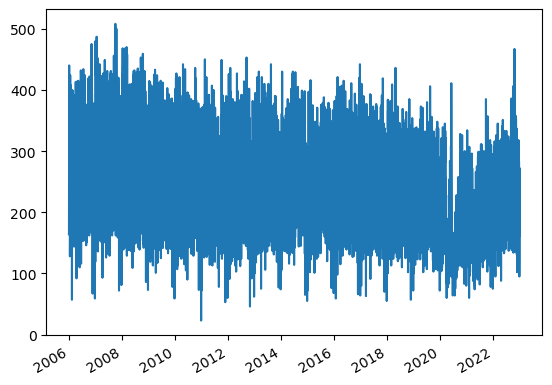

In [20]:
# Plotting felonies over time

arrests['ARREST_DATE'].value_counts().plot(kind="line")

In [21]:
# Adding a new column for day of week based on arrest date

arrests['DOW'] = arrests['ARREST_DATE'].dt.strftime("%a")

<Axes: >

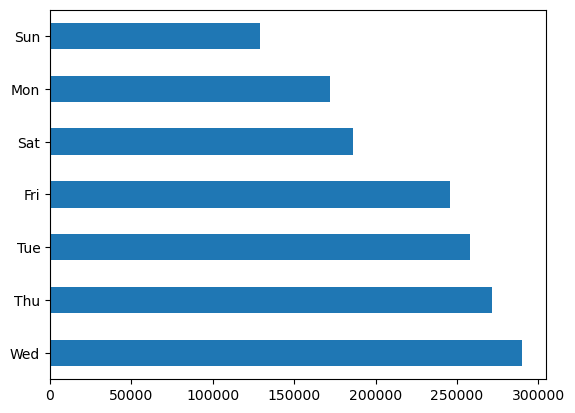

In [22]:
arrests['DOW'].value_counts().plot(kind='barh')

In [23]:
arrests['AGE_GROUP'].value_counts()

25-44      731720
18-24      394619
45-64      267052
<18        146024
65+         13073
895             5
UNKNOWN         3
940             3
896             2
928             2
948             2
934             2
935             2
931             1
942             1
200             1
951             1
924             1
959             1
914             1
949             1
909             1
922             1
812             1
927             1
2000            1
926             1
918             1
1024            1
1953            1
2007            1
932             1
933             1
920             1
912             1
316             1
708             1
956             1
894             1
965             1
910             1
Name: AGE_GROUP, dtype: int64

In [24]:
# Filtering out only the right age groups

correct_age = ['25-44','18-24','45-64','<18','65+']
arrests = arrests[arrests['AGE_GROUP'].isin(correct_age)]
arrests['AGE_GROUP'].value_counts()

25-44    731720
18-24    394619
45-64    267052
<18      146024
65+       13073
Name: AGE_GROUP, dtype: int64

In [25]:
# Checking to see number of offense types and distribution

arrests['OFNS_DESC'].value_counts()

DANGEROUS DRUGS                                296535
FELONY ASSAULT                                 243939
MISCELLANEOUS PENAL LAW                        190682
ROBBERY                                        178251
GRAND LARCENY                                  141237
DANGEROUS WEAPONS                              108138
FORGERY                                         90805
BURGLARY                                        83224
CRIMINAL MISCHIEF & RELATED OFFENSES            54159
POSSESSION OF STOLEN PROPERTY                   21304
GRAND LARCENY OF MOTOR VEHICLE                  18950
CRIMINAL MISCHIEF & RELATED OF                  17553
OTHER STATE LAWS                                14050
RAPE                                            13808
SEX CRIMES                                      12437
MURDER & NON-NEGL. MANSLAUGHTER                 12207
INTOXICATED/IMPAIRED DRIVING                    11815
VEHICLE AND TRAFFIC LAWS                         9931
THEFT-FRAUD                 

In [26]:
# Creating a new column for offense type

arrests['OFFENSE_TYPE'] = arrests['OFNS_DESC']

In [27]:
# Creating new buckets for each of the offense type to reduce its complexity

assault = arrests[arrests['OFFENSE_TYPE'].str.contains('|'.join(['assault','murder']),case=False,na=False)==True]
larceny = arrests[arrests['OFFENSE_TYPE'].str.contains('|'.join(['larceny','thef','stolen','steal']),case=False,na=False)==True]
burglary = arrests[arrests['OFFENSE_TYPE'].str.contains('|'.join(['burglar','trespass']),case=False,na=False)==True]
substance = arrests[arrests['OFFENSE_TYPE'].str.contains('|'.join(['drug','cannabis','alcohol']),case=False,na=False)==True]
motor = arrests[arrests['OFFENSE_TYPE'].str.contains('|'.join(['traffic','driving','car','vehicle']),case=False,na=False)==True]
sex_crimes = arrests[arrests['OFFENSE_TYPE'].str.contains('|'.join(['rape','sex','prostitution']),case=False,na=False)==True]
fraud = arrests[arrests['OFFENSE_TYPE'].str.contains('|'.join(['fraud','forgery']),case=False,na=False)==True]

In [28]:
assault['OFFENSE_TYPE'].value_counts()

FELONY ASSAULT                     243939
MURDER & NON-NEGL. MANSLAUGHTER     12207
MURDER & NON-NEGL. MANSLAUGHTE       5404
Name: OFFENSE_TYPE, dtype: int64

In [29]:
larceny['OFFENSE_TYPE'].value_counts()

GRAND LARCENY                     141237
POSSESSION OF STOLEN PROPERTY      21304
GRAND LARCENY OF MOTOR VEHICLE     18950
THEFT-FRAUD                         9631
Name: OFFENSE_TYPE, dtype: int64

In [30]:
burglary['OFFENSE_TYPE'].value_counts()

BURGLARY    83224
Name: OFFENSE_TYPE, dtype: int64

In [31]:
substance['OFFENSE_TYPE'].value_counts()

DANGEROUS DRUGS              296535
CANNABIS RELATED OFFENSES        59
Name: OFFENSE_TYPE, dtype: int64

In [32]:
motor['OFFENSE_TYPE'].value_counts()

GRAND LARCENY OF MOTOR VEHICLE    18950
INTOXICATED/IMPAIRED DRIVING      11815
VEHICLE AND TRAFFIC LAWS           9931
INTOXICATED & IMPAIRED DRIVING      178
HOMICIDE-NEGLIGENT-VEHICLE          134
Name: OFFENSE_TYPE, dtype: int64

In [33]:
sex_crimes['OFFENSE_TYPE'].value_counts()

RAPE                               13808
SEX CRIMES                         12437
PROSTITUTION & RELATED OFFENSES     1863
FELONY SEX CRIMES                      2
Name: OFFENSE_TYPE, dtype: int64

In [34]:
fraud['OFFENSE_TYPE'].value_counts()

FORGERY        90805
THEFT-FRAUD     9631
FRAUDS            46
Name: OFFENSE_TYPE, dtype: int64

In [35]:
arrests.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,OFNS_DESC,ARREST_BORO,AGE_GROUP,PERP_SEX,PERP_RACE,Community Districts,...,poverty_rate,pct_hh_rent_burd,pct_bach_deg,unemployment,mean_commute,moe_mean_commute,crime_count,crime_per_1000,DOW,OFFENSE_TYPE
0,237354740,2021-12-04,153.0,RAPE 3,RAPE,B,25-44,M,WHITE HISPANIC,8.0,...,32.3,53.8,14.2,6.4,44.9,2.9,864.0,12.3,Sat,RAPE
1,192799737,2019-01-26,177.0,SEXUAL ABUSE,SEX CRIMES,M,45-64,M,BLACK,7.0,...,23.7,38.5,31.3,5.2,35.5,1.8,1934.0,15.1,Sat,SEX CRIMES
2,236106641,2021-11-10,263.0,"ARSON 2,3,4",ARSON,B,25-44,M,WHITE HISPANIC,8.0,...,32.3,53.8,14.2,6.4,44.9,2.9,864.0,12.3,Wed,ARSON
3,238383628,2021-12-28,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",FORGERY,Q,18-24,M,BLACK,41.0,...,17.1,47.1,22.5,5.9,48.6,1.4,2670.0,9.8,Tue,FORGERY
4,149117452,2016-01-06,153.0,RAPE 3,RAPE,K,25-44,M,BLACK,61.0,...,16.8,49.1,24.5,4.7,47.7,1.6,1475.0,8.4,Wed,RAPE


In [36]:
# Mapping most of the offense types to smaller buckets

offense_mapping = {
    'FELONY ASSAULT': 'MURDER',
    'MURDER & NON-NEGL. MANSLAUGHTER': 'MURDER',
    'MURDER & NON-NEGL. MANSLAUGHTE': 'MURDER',
    'HOMICIDE-NEGLIGENT,UNCLASSIFIE': 'MURDER',
    'PETIT LARCENY': 'THEFT',
    'GRAND LARCENY': 'THEFT',
    'OTHER OFFENSES RELATED TO THEF': 'THEFT',
    'POSSESSION OF STOLEN PROPERTY': 'THEFT',
    'GRAND LARCENY OF MOTOR VEHICLE': 'THEFT',
    'THEFT-FRAUD': 'THEFT',
    'THEFT OF SERVICES': 'THEFT',
    'THEFT-FRAUD': 'THEFT',
    'CRIMINAL TRESPASS': 'THEFT',
    'BURGLAR\'S TOOLS': 'THEFT',
    'BURGLARY': 'THEFT',
    'ROBBERY': 'THEFT',
    'DANGEROUS DRUGS': 'SUBSTANCES',
    'CANNABIS RELATED OFFENSES': 'SUBSTANCES',
    'ALCOHOLIC BEVERAGE CONTROL LAW': 'SUBSTANCES',
    'INTOXICATED & IMPAIRED DRIVING': 'MOTOR',
    'INTOXICATED/IMPAIRED DRIVING': 'MOTOR',
    'VEHICLE AND TRAFFIC LAWS': 'MOTOR',
    'HOMICIDE-NEGLIGENT-VEHICLE': 'MOTOR',
    'PARKING OFFENSES': 'MOTOR',
    'OTHER TRAFFIC INFRACTION': 'MOTOR',
    'UNAUTHORIZED USE OF A VEHICLE': 'MOTOR',
    'PROSTITUTION & RELATED OFFENSES': 'SEX CRIMES',
    'FELONY SEX CRIMES': 'SEX CRIMES',
    'RAPE': 'SEX CRIMES',
    'HARRASSMENT 2': 'SEX CRIMES',
    'HARRASSMENT 2': 'SEX CRIMES',
    'OFFENSES INVOLVING FRAUD': 'FRAUD',
    'FORGERY': 'FRAUD',
    'FRAUDS': 'FRAUD',
    'FRAUDULENT ACCOSTING': 'FRAUD',
    'DANGEROUS WEAPONS': 'ARMS',
    'ARSON': 'ARMS',
    'UNLAWFUL POSS. WEAP. ON SCHOOL': 'ARMS',
    'KIDNAPPING & RELATED OFFENSES': 'KIDNAPPING',
    'BURGLARY': 'THEFT',
    'THEFT_FRAUD': 'THEFT',
}

In [37]:
arrests['OFFENSE_TYPE'] = arrests['OFFENSE_TYPE'].replace(offense_mapping)


In [38]:
arrests['OFFENSE_TYPE'].value_counts()

THEFT                                          452597
SUBSTANCES                                     296594
MURDER                                         261646
MISCELLANEOUS PENAL LAW                        190682
ARMS                                           110314
FRAUD                                           90851
CRIMINAL MISCHIEF & RELATED OFFENSES            54159
SEX CRIMES                                      28110
MOTOR                                           22058
CRIMINAL MISCHIEF & RELATED OF                  17553
OTHER STATE LAWS                                14050
NYS LAWS-UNCLASSIFIED FELONY                     3386
GAMBLING                                         2978
KIDNAPPING                                       2287
OTHER STATE LAWS (NON PENAL LAW)                 2285
OTHER STATE LAWS (NON PENAL LA                   1521
CHILD ABANDONMENT/NON SUPPORT 1                   473
ENDAN WELFARE INCOMP                              193
OFF. AGNST PUB ORD SENSBLTY 

In [39]:
offenses = arrests['OFFENSE_TYPE'].unique()
offenses

array(['SEX CRIMES', 'ARMS', 'FRAUD', 'MURDER', 'THEFT',
       'MISCELLANEOUS PENAL LAW', 'SUBSTANCES',
       'CRIMINAL MISCHIEF & RELATED OF', 'NYS LAWS-UNCLASSIFIED FELONY',
       'MOTOR', 'CHILD ABANDONMENT/NON SUPPORT',
       'OFFENSES AGAINST PUBLIC SAFETY', 'GAMBLING', 'KIDNAPPING',
       'OTHER STATE LAWS (NON PENAL LA',
       'KIDNAPPING AND RELATED OFFENSES', 'ENDAN WELFARE INCOMP',
       'CRIMINAL MISCHIEF & RELATED OFFENSES',
       'OFFENSES AGAINST PUBLIC ADMINI', 'OFF. AGNST PUB ORD SENSBLTY &',
       'ESCAPE 3', 'OTHER STATE LAWS', 'OTHER STATE LAWS (NON PENAL LAW)',
       'HOMICIDE-NEGLIGENT,UNCLASSIFIED',
       'OFFENSES AGAINST PUBLIC ADMINISTRATION', 'ABORTION',
       'CHILD ABANDONMENT/NON SUPPORT 1',
       'OFF. AGNST PUB ORD SENSBLTY & RGHTS TO PRIV',
       'ANTICIPATORY OFFENSES', '(null)'], dtype=object)

In [40]:
# For further reduction, removing all crime types that occurred less that 500 times in the last 20 years 

small_crimes = []

for i in offenses:
    if len(arrests[(arrests['OFFENSE_TYPE']==str(i))])<500:
        small_crimes.append(i)

small_crimes

['CHILD ABANDONMENT/NON SUPPORT',
 'OFFENSES AGAINST PUBLIC SAFETY',
 'KIDNAPPING AND RELATED OFFENSES',
 'ENDAN WELFARE INCOMP',
 'OFFENSES AGAINST PUBLIC ADMINI',
 'OFF. AGNST PUB ORD SENSBLTY &',
 'ESCAPE 3',
 'HOMICIDE-NEGLIGENT,UNCLASSIFIED',
 'OFFENSES AGAINST PUBLIC ADMINISTRATION',
 'ABORTION',
 'CHILD ABANDONMENT/NON SUPPORT 1',
 'OFF. AGNST PUB ORD SENSBLTY & RGHTS TO PRIV',
 'ANTICIPATORY OFFENSES',
 '(null)']

In [41]:
# Removing all small crimes

arrests = arrests[~arrests['OFFENSE_TYPE'].isin(small_crimes)]
arrests.shape

(1551071, 67)

In [42]:
arrests['OFFENSE_TYPE'].value_counts()

THEFT                                   452597
SUBSTANCES                              296594
MURDER                                  261646
MISCELLANEOUS PENAL LAW                 190682
ARMS                                    110314
FRAUD                                    90851
CRIMINAL MISCHIEF & RELATED OFFENSES     54159
SEX CRIMES                               28110
MOTOR                                    22058
CRIMINAL MISCHIEF & RELATED OF           17553
OTHER STATE LAWS                         14050
NYS LAWS-UNCLASSIFIED FELONY              3386
GAMBLING                                  2978
KIDNAPPING                                2287
OTHER STATE LAWS (NON PENAL LAW)          2285
OTHER STATE LAWS (NON PENAL LA            1521
Name: OFFENSE_TYPE, dtype: int64

<Axes: >

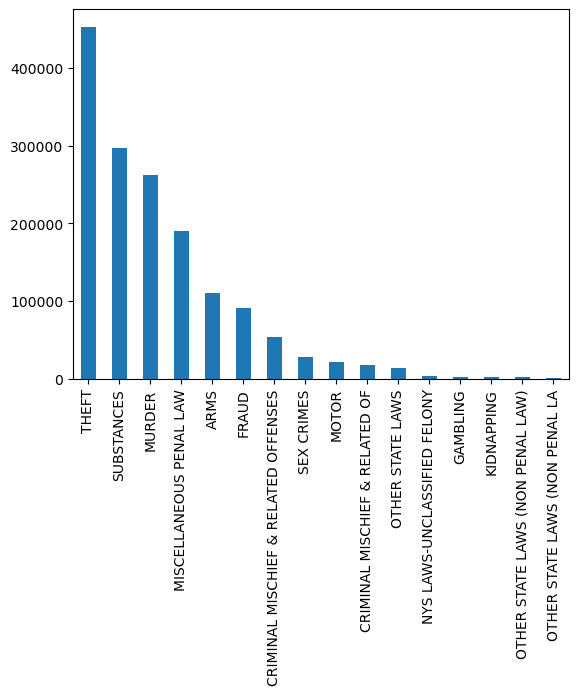

In [43]:
arrests['OFFENSE_TYPE'].value_counts().plot(kind="bar")

In [44]:
# We will now reduce this to 5 of the largest and most "interesting" categories for analysis: Substance, Assault, Theft, Sex Crime, Fraud and Arms

categories = ['THEFT','SUBSTANCES','MURDER','ARMS','FRAUD','SEX CRIMES']

arrests = arrests[arrests['OFFENSE_TYPE'].isin(categories)]

arrests.shape


(1240112, 67)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '18-24'),
  Text(1, 0, '25-44'),
  Text(2, 0, '45-64'),
  Text(3, 0, '65+'),
  Text(4, 0, '<18')])

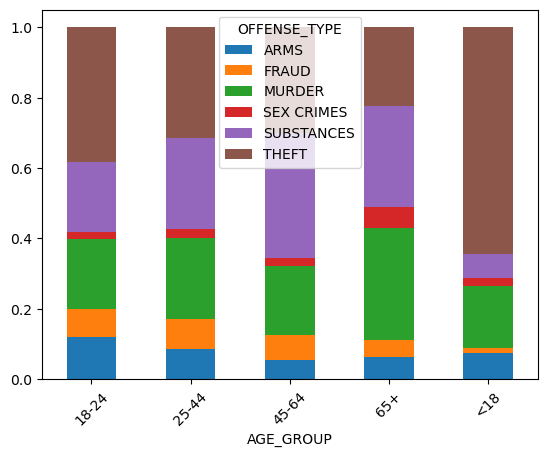

In [45]:
# Breakdown of age group by offense type

arrests.groupby('AGE_GROUP')['OFFENSE_TYPE'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
plt.xticks(rotation=45)

<Axes: xlabel='ARREST_BORO'>

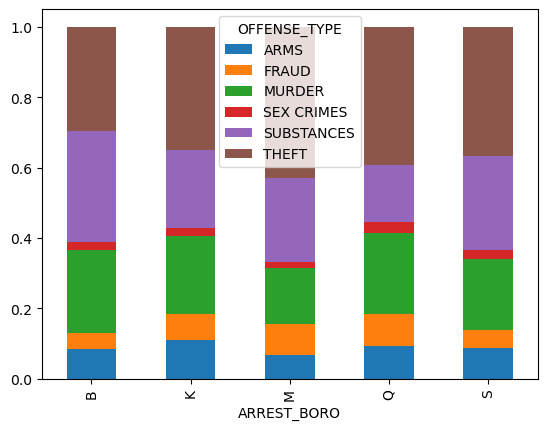

In [46]:
arrests.groupby('ARREST_BORO')['OFFENSE_TYPE'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)


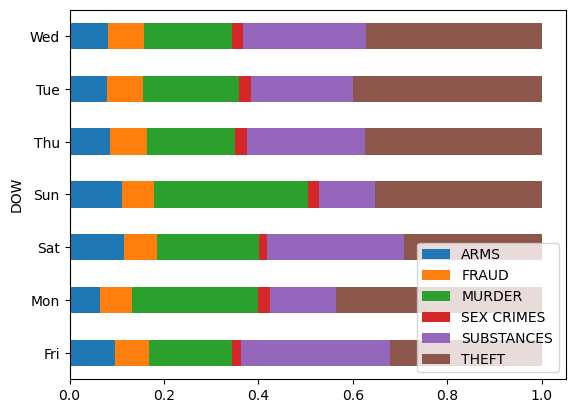

In [47]:
arrests.groupby('DOW')['OFFENSE_TYPE'].value_counts(normalize=True).unstack().plot(kind='barh', stacked=True)
plt.legend(loc='lower right')


## REGRESSION

In [48]:
# Now separating out our first dataframe for analysis

by_cd = arrests[['DOW','ARREST_BORO','AGE_GROUP','cd_number','pop_estimate_acs','pop_change_00_10','under18_rate','pct_foreign_born','lep_rate','poverty_rate','pct_hh_rent_burd','pct_bach_deg','unemployment','mean_commute','OFFENSE_TYPE']]

In [49]:
by_cd

,DOW,ARREST_BORO,AGE_GROUP,cd_number,pop_estimate_acs,pop_change_00_10,under18_rate,pct_foreign_born,lep_rate,poverty_rate,pct_hh_rent_burd,pct_bach_deg,unemployment,mean_commute,OFFENSE_TYPE
0,Sat,B,25-44,202.0,70144.0,0.12,27.5,34.6,30.6,32.3,53.8,14.2,6.4,44.9,SEX CRIMES
1,Sat,M,45-64,111.0,128205.0,0.02,20.4,23.5,18.9,23.7,38.5,31.3,5.2,35.5,SEX CRIMES
2,Wed,B,25-44,202.0,70144.0,0.12,27.5,34.6,30.6,32.3,53.8,14.2,6.4,44.9,ARMS
3,Tue,Q,18-24,412.0,272534.0,0.01,22.5,43.2,15.4,17.1,47.1,22.5,5.9,48.6,FRAUD
4,Wed,K,25-44,317.0,176485.0,-0.06,21.1,51.4,9.2,16.8,49.1,24.5,4.7,47.7,SEX CRIMES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558071,Thu,Q,18-24,410.0,138765.0,-0.04,20.7,45.2,13.7,17.0,50.0,22.3,4.8,46.2,ARMS
1558072,Wed,M,45-64,107.0,212034.0,0.01,15.2,22.9,9.2,9.2,32.3,75.3,3.3,32.4,MURDER
1558073,Thu,M,<18,110.0,147194.0,0.08,20.3,24.7,12.4,20.6,39.0,39.0,6.2,37.4,THEFT
1558074,Sun,K,25-44,307.0,153032.0,0.05,22.8,43.3,43.6,23.9,45.4,35.0,3.8,43.0,SUBSTANCES


In [50]:
# Dummy the offense type column

dummy_df = pd.get_dummies(by_cd['OFFENSE_TYPE'])

In [51]:
dummy_df

,ARMS,FRAUD,MURDER,SEX CRIMES,SUBSTANCES,THEFT
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
1558071,1,0,0,0,0,0
1558072,0,0,1,0,0,0
1558073,0,0,0,0,0,1
1558074,0,0,0,0,1,0


In [52]:
by_cd = pd.concat([by_cd, dummy_df], axis=1)

In [53]:
by_cd

,DOW,ARREST_BORO,AGE_GROUP,cd_number,pop_estimate_acs,pop_change_00_10,under18_rate,pct_foreign_born,lep_rate,poverty_rate,...,pct_bach_deg,unemployment,mean_commute,OFFENSE_TYPE,ARMS,FRAUD,MURDER,SEX CRIMES,SUBSTANCES,THEFT
0,Sat,B,25-44,202.0,70144.0,0.12,27.5,34.6,30.6,32.3,...,14.2,6.4,44.9,SEX CRIMES,0,0,0,1,0,0
1,Sat,M,45-64,111.0,128205.0,0.02,20.4,23.5,18.9,23.7,...,31.3,5.2,35.5,SEX CRIMES,0,0,0,1,0,0
2,Wed,B,25-44,202.0,70144.0,0.12,27.5,34.6,30.6,32.3,...,14.2,6.4,44.9,ARMS,1,0,0,0,0,0
3,Tue,Q,18-24,412.0,272534.0,0.01,22.5,43.2,15.4,17.1,...,22.5,5.9,48.6,FRAUD,0,1,0,0,0,0
4,Wed,K,25-44,317.0,176485.0,-0.06,21.1,51.4,9.2,16.8,...,24.5,4.7,47.7,SEX CRIMES,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558071,Thu,Q,18-24,410.0,138765.0,-0.04,20.7,45.2,13.7,17.0,...,22.3,4.8,46.2,ARMS,1,0,0,0,0,0
1558072,Wed,M,45-64,107.0,212034.0,0.01,15.2,22.9,9.2,9.2,...,75.3,3.3,32.4,MURDER,0,0,1,0,0,0
1558073,Thu,M,<18,110.0,147194.0,0.08,20.3,24.7,12.4,20.6,...,39.0,6.2,37.4,THEFT,0,0,0,0,0,1
1558074,Sun,K,25-44,307.0,153032.0,0.05,22.8,43.3,43.6,23.9,...,35.0,3.8,43.0,SUBSTANCES,0,0,0,0,1,0


In [54]:
# Grouping to get total volume of crimes by community district

cd_group = by_cd.groupby('cd_number').agg({'ARREST_BORO':'first','pop_estimate_acs':'first','pop_change_00_10':'first','under18_rate':'first','pct_foreign_born':'first','lep_rate':'first','poverty_rate':'first','pct_hh_rent_burd':'first','pct_bach_deg':'first','unemployment':'first','mean_commute':'mean','OFFENSE_TYPE':'count','ARMS':'sum','FRAUD':'sum','MURDER':'sum','SEX CRIMES':'sum','SUBSTANCES':'sum','THEFT':'sum'}) 
cd_group

,ARREST_BORO,pop_estimate_acs,pop_change_00_10,under18_rate,pct_foreign_born,lep_rate,poverty_rate,pct_hh_rent_burd,pct_bach_deg,unemployment,mean_commute,OFFENSE_TYPE,ARMS,FRAUD,MURDER,SEX CRIMES,SUBSTANCES,THEFT
cd_number,,,,,,,,,,,,,,,,,,
101.0,M,75100.0,0.77,16.7,28.1,9.6,7.9,28.4,78.8,2.7,26.1,19812,734,2559,2464,156,1539,12360
102.0,M,88480.0,-0.03,9.4,21.5,6.1,7.9,33.4,80.4,2.9,24.9,19155,784,1902,2101,125,3754,10489
103.0,M,154995.0,-0.01,11.4,34.5,28.1,21.5,38.4,43.3,3.6,31.3,32170,2156,1950,5389,984,8247,13444
104.0,M,129797.0,0.18,8.8,31.8,11.9,11.8,33.6,71.2,3.6,27.8,34907,1348,2711,4535,676,7094,18543
105.0,M,76405.0,0.17,8.4,26.4,6.4,11.8,33.2,82.3,3.2,24.0,30922,1342,5621,3079,53,3882,16945
106.0,M,159623.0,0.05,9.0,24.9,6.8,9.0,35.2,80.3,2.5,27.5,14658,608,1247,2428,429,1453,8493
107.0,M,212034.0,0.01,15.2,22.9,9.2,9.2,32.3,75.3,3.3,32.4,15607,591,1129,2729,191,2433,8534
108.0,M,215449.0,0.01,14.6,23.6,5.4,6.3,32.5,80.5,2.0,31.4,12430,237,1303,1450,144,522,8774
109.0,M,112573.0,-0.01,15.5,34.9,19.3,20.2,45.4,43.9,3.8,36.7,20720,1569,1092,4030,215,6443,7371


In [55]:
# Creating a new column for offense types by rates

cd_group['OFFENSE_RATE'] = cd_group['OFFENSE_TYPE'] / cd_group['pop_estimate_acs']
cd_group['ARMS RATE'] = cd_group['ARMS'] / cd_group['pop_estimate_acs']
cd_group['FRAUD RATE'] = cd_group['FRAUD'] / cd_group['pop_estimate_acs']
cd_group['MURDER RATE'] = cd_group['MURDER'] / cd_group['pop_estimate_acs']
cd_group['SEX CRIMES RATE'] = cd_group['SEX CRIMES'] / cd_group['pop_estimate_acs']
cd_group['SUBSTANCES RATE'] = cd_group['SUBSTANCES'] / cd_group['pop_estimate_acs']
cd_group['THEFT RATE'] = cd_group['THEFT'] / cd_group['pop_estimate_acs']

cd_group

,ARREST_BORO,pop_estimate_acs,pop_change_00_10,under18_rate,pct_foreign_born,lep_rate,poverty_rate,pct_hh_rent_burd,pct_bach_deg,unemployment,...,SEX CRIMES,SUBSTANCES,THEFT,OFFENSE_RATE,ARMS RATE,FRAUD RATE,MURDER RATE,SEX CRIMES RATE,SUBSTANCES RATE,THEFT RATE
cd_number,,,,,,,,,,,,,,,,,,,,,
101.0,M,75100.0,0.77,16.7,28.1,9.6,7.9,28.4,78.8,2.7,...,156,1539,12360,0.263808,0.009774,0.034075,0.032810,0.002077,0.020493,0.164581
102.0,M,88480.0,-0.03,9.4,21.5,6.1,7.9,33.4,80.4,2.9,...,125,3754,10489,0.216490,0.008861,0.021496,0.023745,0.001413,0.042428,0.118547
103.0,M,154995.0,-0.01,11.4,34.5,28.1,21.5,38.4,43.3,3.6,...,984,8247,13444,0.207555,0.013910,0.012581,0.034769,0.006349,0.053208,0.086738
104.0,M,129797.0,0.18,8.8,31.8,11.9,11.8,33.6,71.2,3.6,...,676,7094,18543,0.268935,0.010385,0.020886,0.034939,0.005208,0.054655,0.142862
105.0,M,76405.0,0.17,8.4,26.4,6.4,11.8,33.2,82.3,3.2,...,53,3882,16945,0.404712,0.017564,0.073568,0.040298,0.000694,0.050808,0.221779
106.0,M,159623.0,0.05,9.0,24.9,6.8,9.0,35.2,80.3,2.5,...,429,1453,8493,0.091829,0.003809,0.007812,0.015211,0.002688,0.009103,0.053207
107.0,M,212034.0,0.01,15.2,22.9,9.2,9.2,32.3,75.3,3.3,...,191,2433,8534,0.073606,0.002787,0.005325,0.012871,0.000901,0.011475,0.040248
108.0,M,215449.0,0.01,14.6,23.6,5.4,6.3,32.5,80.5,2.0,...,144,522,8774,0.057693,0.001100,0.006048,0.006730,0.000668,0.002423,0.040724
109.0,M,112573.0,-0.01,15.5,34.9,19.3,20.2,45.4,43.9,3.8,...,215,6443,7371,0.184058,0.013938,0.009700,0.035799,0.001910,0.057234,0.065478


In [56]:
# Setting up X for Linear Regression model

X = cd_group[cd_group.columns[3:11]]
X

,under18_rate,pct_foreign_born,lep_rate,poverty_rate,pct_hh_rent_burd,pct_bach_deg,unemployment,mean_commute
cd_number,,,,,,,,
101.0,16.7,28.1,9.6,7.9,28.4,78.8,2.7,26.1
102.0,9.4,21.5,6.1,7.9,33.4,80.4,2.9,24.9
103.0,11.4,34.5,28.1,21.5,38.4,43.3,3.6,31.3
104.0,8.8,31.8,11.9,11.8,33.6,71.2,3.6,27.8
105.0,8.4,26.4,6.4,11.8,33.2,82.3,3.2,24.0
106.0,9.0,24.9,6.8,9.0,35.2,80.3,2.5,27.5
107.0,15.2,22.9,9.2,9.2,32.3,75.3,3.3,32.4
108.0,14.6,23.6,5.4,6.3,32.5,80.5,2.0,31.4
109.0,15.5,34.9,19.3,20.2,45.4,43.9,3.8,36.7


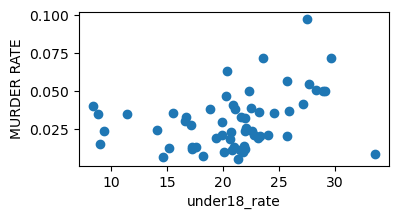

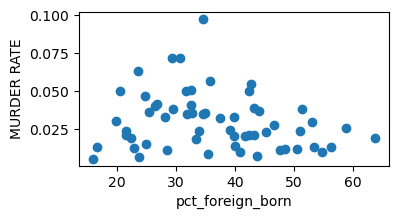

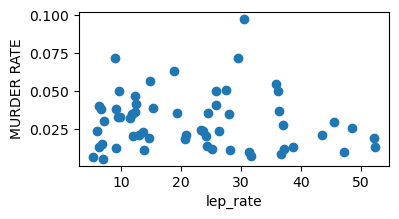

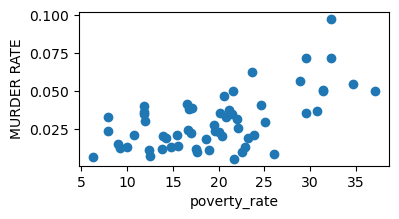

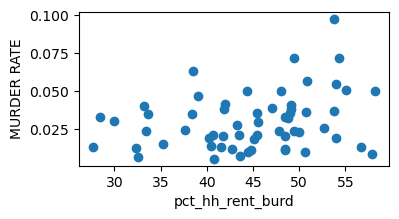

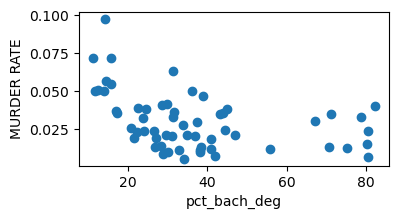

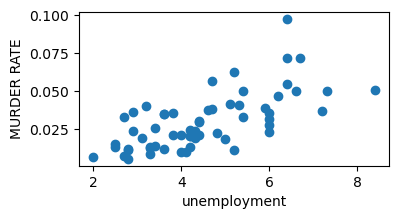

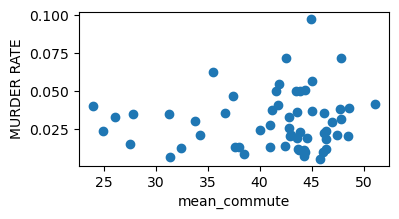

In [57]:
# Plotting the underlying attributes against murder rate

y = cd_group['MURDER RATE']


for col in X.columns: 
    plt.figure(figsize=(4,2))
    plt.scatter(X[col], y)
    plt.ylabel('MURDER RATE')
    plt.xlabel(col)
    plt.show()

In [58]:
# Run OLS regression analysis on Offense Rate
y = cd_group['OFFENSE_RATE']

X_withconstant = sm.add_constant(X) #add constant
OLS = sm.OLS(y,X_withconstant) #instantiate
OLS_results = OLS.fit() #fit
OLS_results.summary() #summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           OFFENSE_RATE   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     10.98
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           8.86e-09
Time:                        22:02:49   Log-Likelihood:                 87.447
No. Observations:                  59   AIC:                            -156.9
Df Residuals:                      50   BIC:                            -138.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5269      0.186      2.840      0.007       0.154       0.899
under18_rate        -0.0023      0.003     -0.776      0.441      -0.008       0.004
pct_foreign_born     0.0014      0.001      0.940      0.352      -0.002       0.004
lep_rate            -0.0035      0.001     -2.898      0.006      -0.006      -0.001
poverty_rate         0.0078      0.003      2.808      0.007       0.002       0.013
pct_hh_rent_burd    -0.0015      0.003     -0.566      0.574      -0.007       0.004
pct_bach_deg        -0.0015      0.001     -1.263      0.212      -0.004       0.001
unemployment         0.0183      0.010      1.913      0.061      -0.001       0.038
mean_commute        -0.0102      0.003     -3.954      0.000      -0.015      -0.005
==============================================================================
Omnibus:                        9.564   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.087
Skew:                           0.882   Prob(JB):                       0.0106
Kurtosis:                       3.765   Cond. No.                     2.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
# Next we will run logistic regression for coefficients across all subsects of Offense Types

In [60]:
X = by_cd[by_cd.columns[4:12]]

X

,pop_estimate_acs,pop_change_00_10,under18_rate,pct_foreign_born,lep_rate,poverty_rate,pct_hh_rent_burd,pct_bach_deg
0,70144.0,0.12,27.5,34.6,30.6,32.3,53.8,14.2
1,128205.0,0.02,20.4,23.5,18.9,23.7,38.5,31.3
2,70144.0,0.12,27.5,34.6,30.6,32.3,53.8,14.2
3,272534.0,0.01,22.5,43.2,15.4,17.1,47.1,22.5
4,176485.0,-0.06,21.1,51.4,9.2,16.8,49.1,24.5
...,...,...,...,...,...,...,...,...
1558071,138765.0,-0.04,20.7,45.2,13.7,17.0,50.0,22.3
1558072,212034.0,0.01,15.2,22.9,9.2,9.2,32.3,75.3
1558073,147194.0,0.08,20.3,24.7,12.4,20.6,39.0,39.0
1558074,153032.0,0.05,22.8,43.3,43.6,23.9,45.4,35.0


Optimization terminated successfully.
         Current function value: 102.511662
         Iterations 5


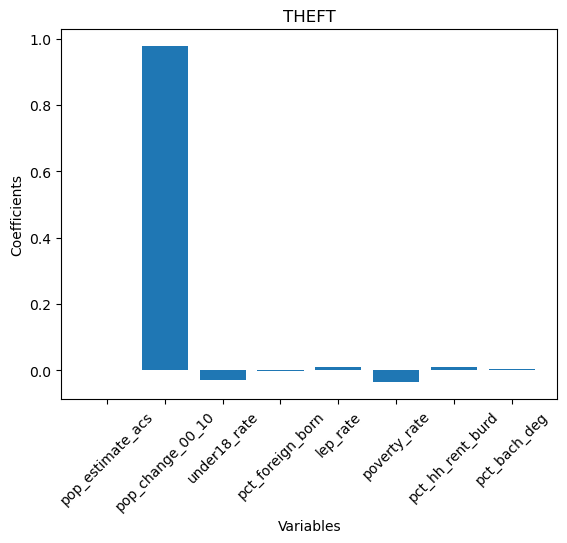

Optimization terminated successfully.
         Current function value: 242.291194
         Iterations 6


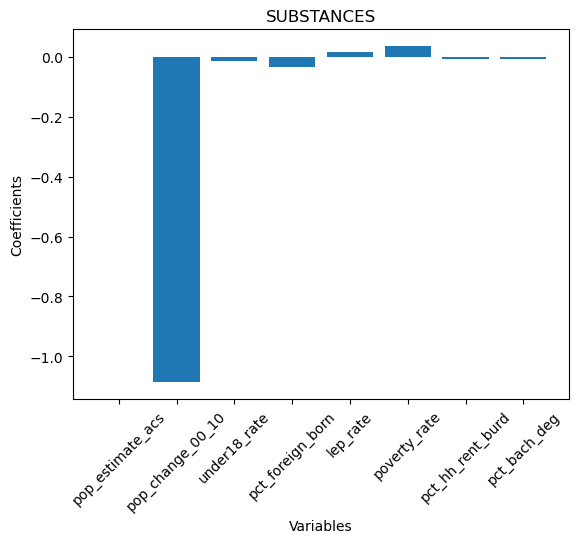

Optimization terminated successfully.
         Current function value: 270.787992
         Iterations 6


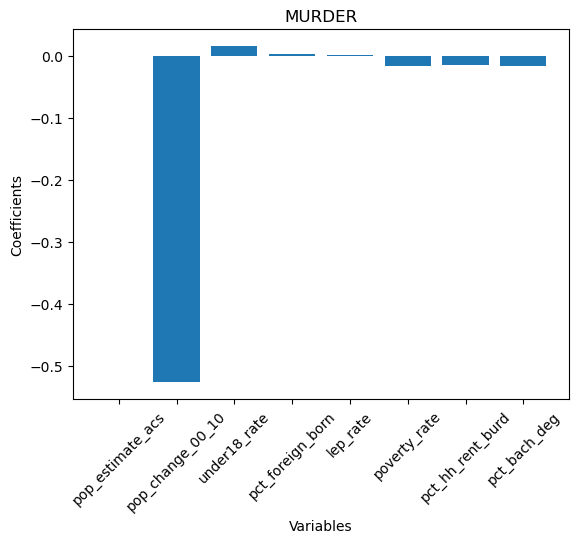

/Users/abbascauser/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/abbascauser/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 7


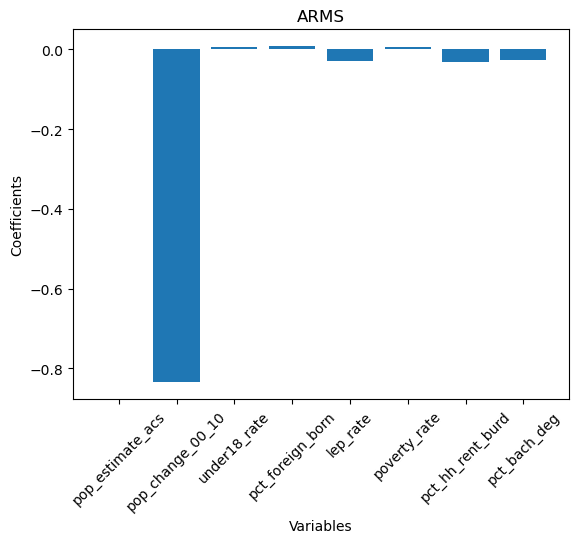

/Users/abbascauser/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/abbascauser/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 7


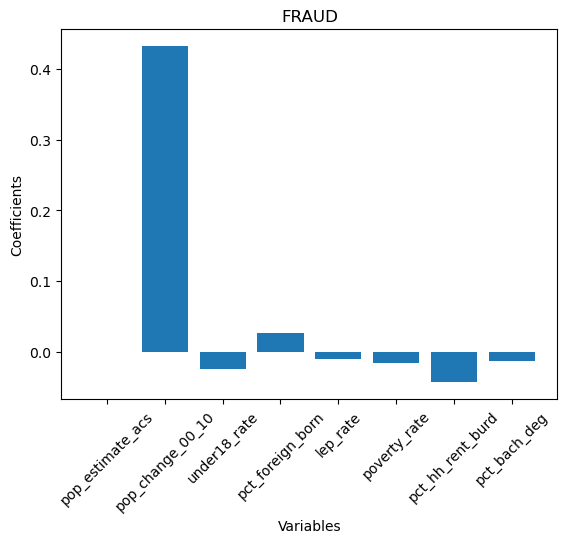

/Users/abbascauser/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/abbascauser/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: inf
         Iterations 8


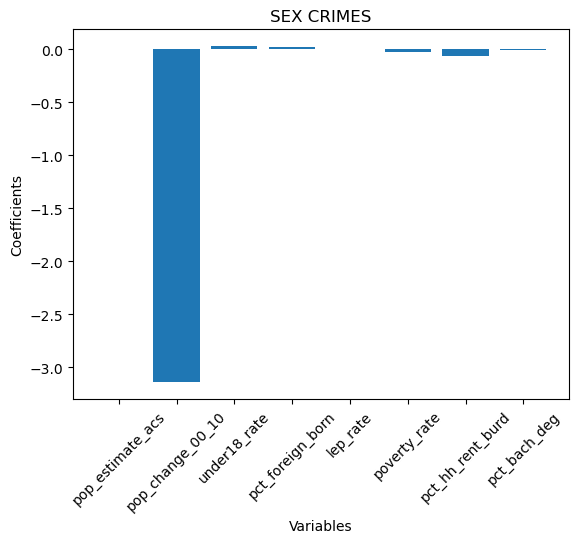

In [61]:
# Run a logsitics regression against each offense type and print out the coefficients of the model. Did not add constant here because I wanted to show the coefficients without it

for i in categories:
    y = by_cd[i]
    log= sm.Logit(y,X)    
    log_results = log.fit()
    coefficients = log_results.params
    plt.bar(coefficients.index, coefficients)
    plt.xlabel('Variables')
    plt.ylabel('Coefficients')
    plt.xticks(rotation=45)
    plt.title(i)
    plt.show()
    

## CLASSIFICATION

In [62]:
arrests.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,OFNS_DESC,ARREST_BORO,AGE_GROUP,PERP_SEX,PERP_RACE,Community Districts,...,poverty_rate,pct_hh_rent_burd,pct_bach_deg,unemployment,mean_commute,moe_mean_commute,crime_count,crime_per_1000,DOW,OFFENSE_TYPE
0,237354740,2021-12-04,153.0,RAPE 3,RAPE,B,25-44,M,WHITE HISPANIC,8.0,...,32.3,53.8,14.2,6.4,44.9,2.9,864.0,12.3,Sat,SEX CRIMES
1,192799737,2019-01-26,177.0,SEXUAL ABUSE,SEX CRIMES,M,45-64,M,BLACK,7.0,...,23.7,38.5,31.3,5.2,35.5,1.8,1934.0,15.1,Sat,SEX CRIMES
2,236106641,2021-11-10,263.0,"ARSON 2,3,4",ARSON,B,25-44,M,WHITE HISPANIC,8.0,...,32.3,53.8,14.2,6.4,44.9,2.9,864.0,12.3,Wed,ARMS
3,238383628,2021-12-28,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",FORGERY,Q,18-24,M,BLACK,41.0,...,17.1,47.1,22.5,5.9,48.6,1.4,2670.0,9.8,Tue,FRAUD
4,149117452,2016-01-06,153.0,RAPE 3,RAPE,K,25-44,M,BLACK,61.0,...,16.8,49.1,24.5,4.7,47.7,1.6,1475.0,8.4,Wed,SEX CRIMES


In [63]:
arrests.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1240112 entries, 0 to 1558077
Data columns (total 67 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   ARREST_KEY              1240112 non-null  int64         
 1   ARREST_DATE             1240112 non-null  datetime64[ns]
 2   PD_CD                   1240112 non-null  float64       
 3   PD_DESC                 1240112 non-null  object        
 4   OFNS_DESC               1240112 non-null  object        
 5   ARREST_BORO             1240112 non-null  object        
 6   AGE_GROUP               1240112 non-null  object        
 7   PERP_SEX                1240112 non-null  object        
 8   PERP_RACE               1240112 non-null  object        
 9   Community Districts     1240089 non-null  float64       
 10  cd_number               1240112 non-null  float64       
 11  pop_2000                1240112 non-null  float64       
 12  pop_2010      

In [64]:
# Creating a new X / y for classification 

X_class = by_cd[['DOW','ARREST_BORO','AGE_GROUP','pct_foreign_born','lep_rate','poverty_rate','pct_hh_rent_burd','pct_bach_deg','unemployment','mean_commute']]

X_class


,DOW,ARREST_BORO,AGE_GROUP,pct_foreign_born,lep_rate,poverty_rate,pct_hh_rent_burd,pct_bach_deg,unemployment,mean_commute
0,Sat,B,25-44,34.6,30.6,32.3,53.8,14.2,6.4,44.9
1,Sat,M,45-64,23.5,18.9,23.7,38.5,31.3,5.2,35.5
2,Wed,B,25-44,34.6,30.6,32.3,53.8,14.2,6.4,44.9
3,Tue,Q,18-24,43.2,15.4,17.1,47.1,22.5,5.9,48.6
4,Wed,K,25-44,51.4,9.2,16.8,49.1,24.5,4.7,47.7
...,...,...,...,...,...,...,...,...,...,...
1558071,Thu,Q,18-24,45.2,13.7,17.0,50.0,22.3,4.8,46.2
1558072,Wed,M,45-64,22.9,9.2,9.2,32.3,75.3,3.3,32.4
1558073,Thu,M,<18,24.7,12.4,20.6,39.0,39.0,6.2,37.4
1558074,Sun,K,25-44,43.3,43.6,23.9,45.4,35.0,3.8,43.0


In [65]:
# Dummying age group, arrest borough and day of week

dummy_df = pd.get_dummies(X_class[['AGE_GROUP','ARREST_BORO','DOW']])
X_class = pd.concat([X_class, dummy_df], axis=1)
X_class = X_class.drop(['AGE_GROUP','ARREST_BORO','DOW'],axis=1)

In [66]:
# Scaling independent variables

scaler = StandardScaler()
scaler.fit(X_class)
X_scaled = scaler.transform(X_class)

In [67]:
X_scaled

array([[-0.0790226 ,  0.74765144,  1.45769332, ..., -0.46239588,
        -0.44806324, -0.48172275],
       [-1.1410574 , -0.19825903,  0.34142167, ..., -0.46239588,
        -0.44806324, -0.48172275],
       [-0.0790226 ,  0.74765144,  1.45769332, ..., -0.46239588,
        -0.44806324,  2.07588284],
       ...,
       [-1.02624283, -0.72376485, -0.06095532, ...,  2.16264902,
        -0.44806324, -0.48172275],
       [ 0.75338306,  1.79866308,  0.36738148, ..., -0.46239588,
        -0.44806324, -0.48172275],
       [ 1.71973906,  1.40251254, -0.81378969, ..., -0.46239588,
         2.23182779, -0.48172275]])

<Axes: >

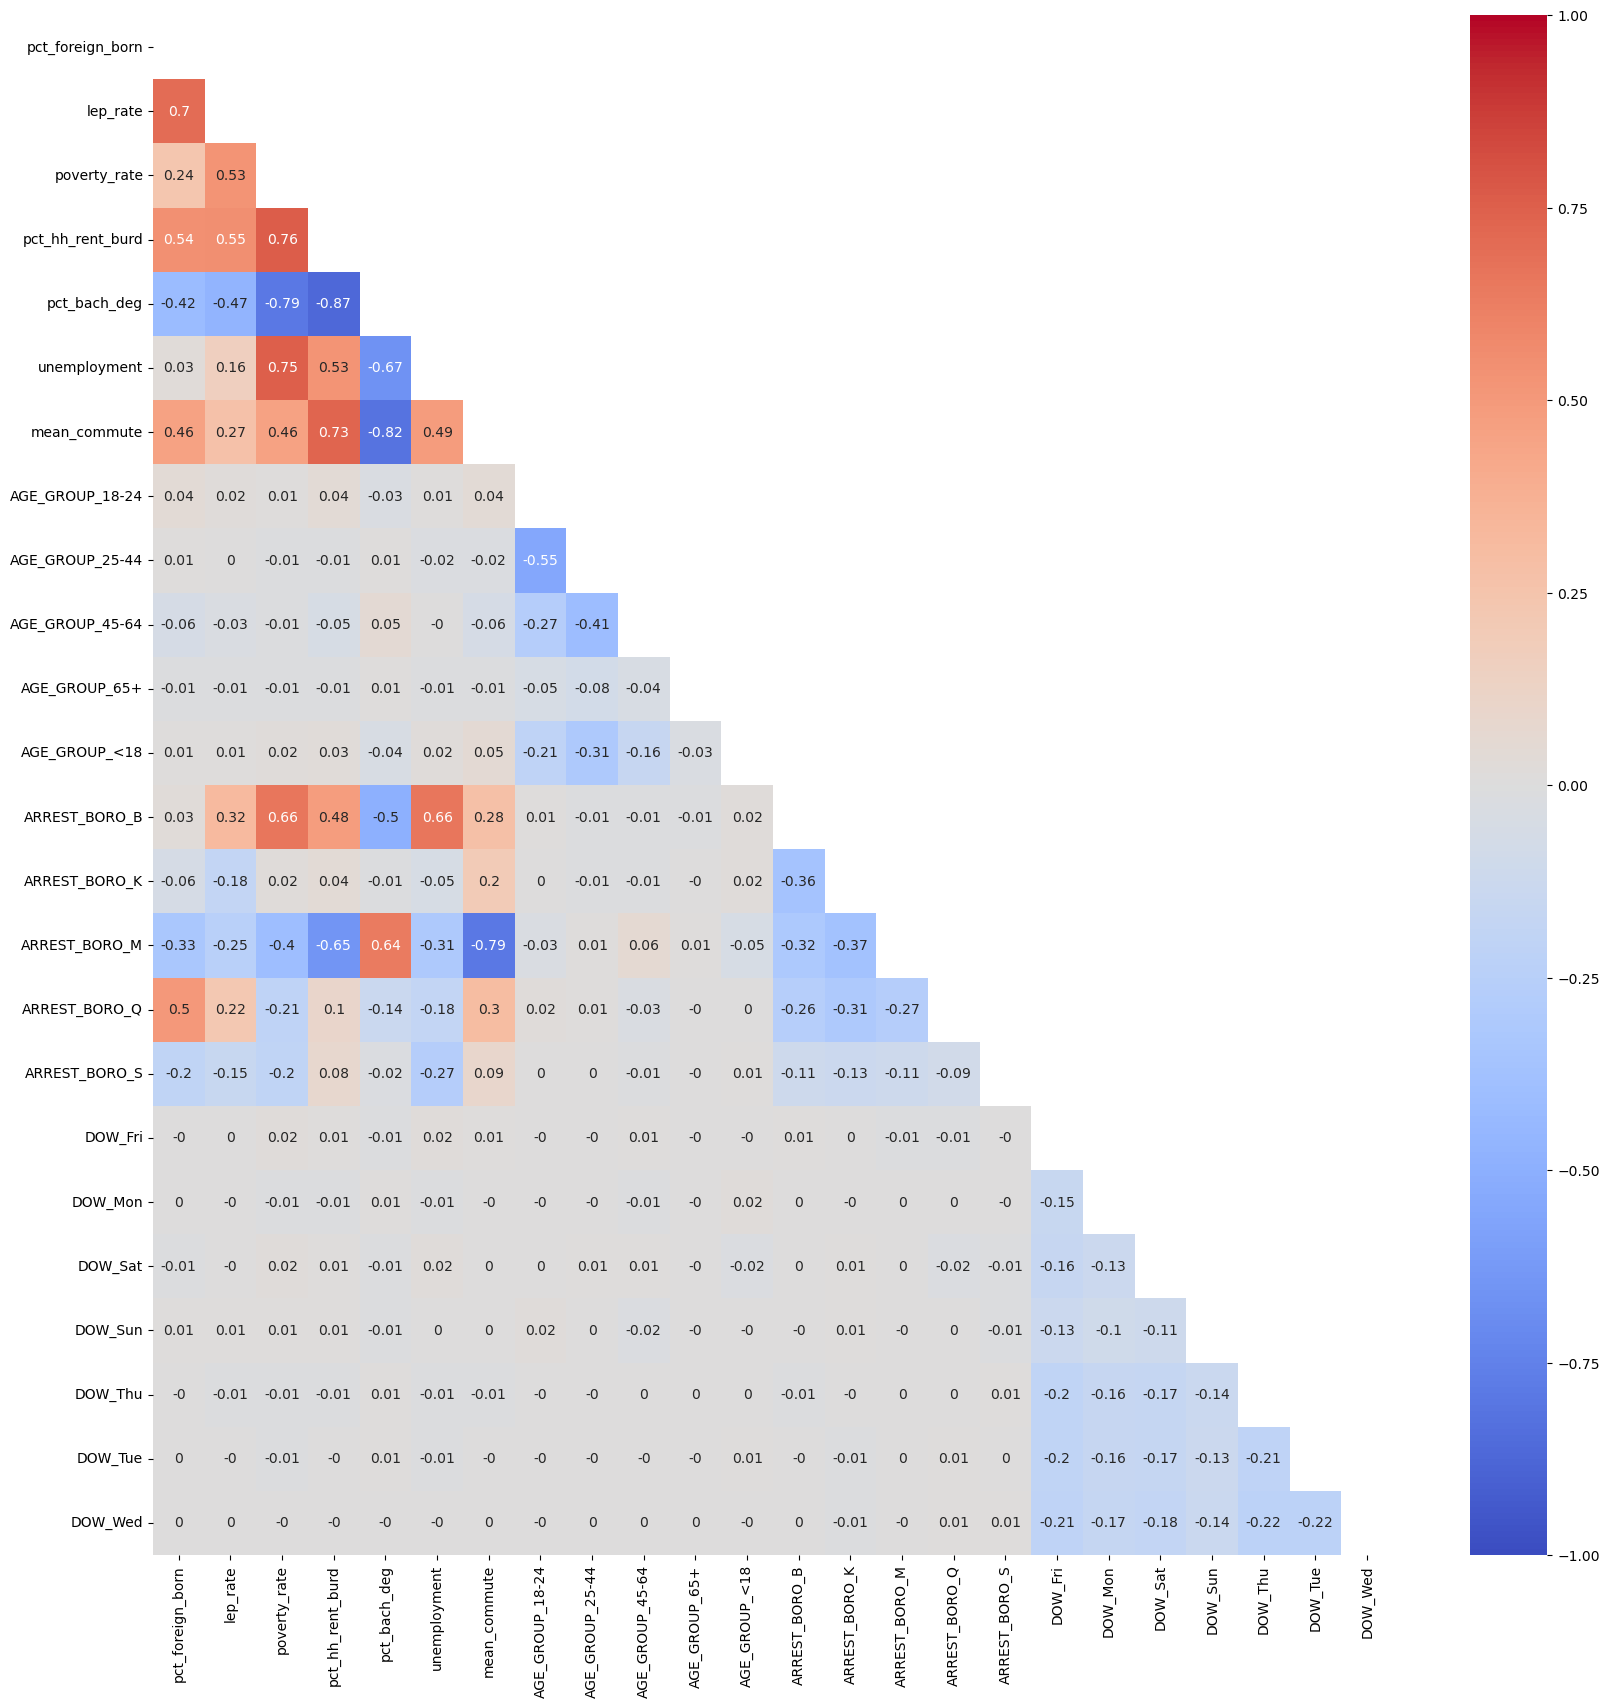

In [68]:
# Looking at collinearity

corrDf = X_class.corr()
mask = np.triu(corrDf)

plt.figure(figsize=(20,20))
sns.heatmap(corrDf.round(2), annot=True, mask=mask, cmap='coolwarm',vmin=-1,vmax=1)

In [69]:
y = by_cd['OFFENSE_TYPE']

In [70]:
# Running a regression model

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=17)

# 1. Instantiate model 
logistic_regression_model = LogisticRegression()

# 2. Fit model on the training data
logistic_regression_model.fit(X_train, y_train)

# 3. Score on the training data 
print(logistic_regression_model.score(X_train, y_train))

# 4. Score on the testing data
print(logistic_regression_model.score(X_test, y_test))



/Users/abbascauser/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.42358598875705705
0.424827536155921


In [71]:
# Now running a decision tree

DT_model = DecisionTreeClassifier(max_depth = 6)
DT_model.fit(X_train, y_train)

print(f"The TRAIN classification accuracy is:  {DT_model.score(X_train,y_train)}")
print(f"The TEST classification accuracy is:  {DT_model.score(X_test,y_test)}")

The TRAIN classification accuracy is:  0.41108509418005845
The TEST classification accuracy is:  0.41114735326965646
